# README

# Import dependencies

In [1]:
using Pkg
Pkg.add(["CSV", "DataFrames", "Plots", "MLJ", "MLJFlux", "MLJIteration", "Statistics", 
        "MLJDecisionTreeInterface", "NearestNeighborModels", "MLJLinearModels", 
        "MLJMultivariateStatsInterface", "MLJLIBSVMInterface","LightGBM"])

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [2]:
using DataFrames, MLJ, Statistics, Flux, MLJMultivariateStatsInterface, Plots, MLJLinearModels, 
    MLJLIBSVMInterface, LightGBM
import MLJFlux, CSV, MLJDecisionTreeInterface, NearestNeighborModels

## Read data

In [3]:
data = CSV.File("data/train.csv") |> DataFrame;

In [4]:
describe(data)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,PassengerId,446.0,1,446.0,891
2,Survived,0.383838,0,0.0,1
3,Pclass,2.30864,1,3.0,3
4,Name,,"Abbing, Mr. Anthony",,"van Melkebeke, Mr. Philemon"
5,Sex,,female,,male
6,Age,29.6991,0.42,28.0,80.0
7,SibSp,0.523008,0,0.0,8
8,Parch,0.381594,0,0.0,6
9,Ticket,,110152,,WE/P 5735


## Clean data

### Encode sex column
male -> 0, female -> 1

In [5]:
data.Sex = map(x -> x == "male" ? 0 : 1, data.Sex)

891-element PooledArrays.PooledVector{Int64, UInt32, Vector{UInt32}}:
 0
 1
 1
 1
 0
 0
 0
 0
 1
 1
 1
 1
 0
 ⋮
 1
 1
 0
 1
 0
 0
 1
 0
 1
 1
 0
 0

### Extract title from name

In [6]:
# all titles found in name
titles_list = ["Mrs", "Mr", "Master", "Miss", "Major", "Rev",
                    "Dr", "Ms", "Mlle","Col", "Capt", "Mme", "Countess",
                    "Don", "Jonkheer"]

# function to translate name to title eg: mr, miss, master, doctor etc
function substring_in_string(big_string::String, substrings::Vector{String})
    for substring in substrings
        if occursin(substring, big_string)
            return substring
        end
    end
    return missing
end

substring_in_string (generic function with 1 method)

In [7]:
rename!(data, :Name => :Title)
data.Title = map(x -> substring_in_string(x, titles_list), data.Title)

891-element Vector{String}:
 "Mr"
 "Mrs"
 "Miss"
 "Mrs"
 "Mr"
 "Mr"
 "Mr"
 "Master"
 "Mrs"
 "Mrs"
 "Miss"
 "Miss"
 "Mr"
 ⋮
 "Mrs"
 "Mrs"
 "Mr"
 "Miss"
 "Mr"
 "Mr"
 "Mrs"
 "Rev"
 "Miss"
 "Miss"
 "Mr"
 "Mr"

### Plot how frequent each title is

In [8]:
all_titles = data.Title

891-element Vector{String}:
 "Mr"
 "Mrs"
 "Miss"
 "Mrs"
 "Mr"
 "Mr"
 "Mr"
 "Master"
 "Mrs"
 "Mrs"
 "Miss"
 "Miss"
 "Mr"
 ⋮
 "Mrs"
 "Mrs"
 "Mr"
 "Miss"
 "Mr"
 "Mr"
 "Mrs"
 "Rev"
 "Miss"
 "Miss"
 "Mr"
 "Mr"

In [9]:
titles = unique(all_titles)

15-element Vector{String}:
 "Mr"
 "Mrs"
 "Miss"
 "Master"
 "Don"
 "Rev"
 "Dr"
 "Mme"
 "Ms"
 "Major"
 "Mlle"
 "Col"
 "Capt"
 "Countess"
 "Jonkheer"

In [10]:
freq_array = []
for title in titles
    freq_of_title = count(all_titles .== title)
    push!(freq_array, freq_of_title)
end

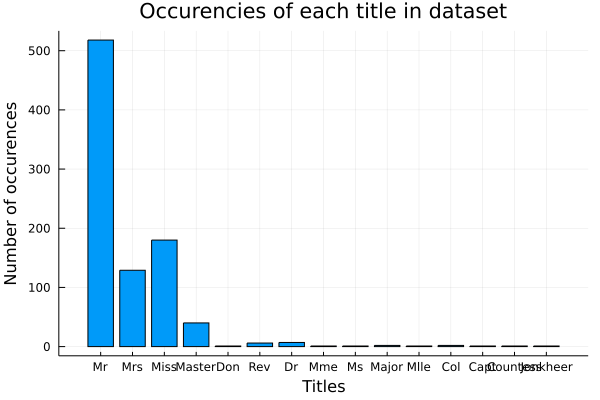

In [11]:
bar(titles, freq_array, 
    title="Occurencies of each title in dataset", 
    xlabel="Titles",
    ylabel="Number of occurences",
    legend=false)

### Encode titles
Mr -> 0, Mrs-> 1 etc

In [12]:
# function for encoding titles
# replaces titles with its index in the titles array
function title_to_numerical(value)
    return findfirst(isequal(value), titles_list) - 1
end

title_to_numerical (generic function with 1 method)

In [13]:
data.Title = map(x -> title_to_numerical(x), data.Title)

891-element Vector{Int64}:
 1
 0
 3
 0
 1
 1
 1
 2
 0
 0
 3
 3
 1
 ⋮
 0
 0
 1
 3
 1
 1
 0
 5
 3
 3
 1
 1

### Put titles in categories based on frequency
Mr(encoded as 0) -> 0,
Mrs(1) -> 1,
Miss(2) -> 2,
rest -> 3

In [14]:
function categorize_numerical_title(value)
   if value > 2
        return 3
    else
        return value
    end
end

categorize_numerical_title (generic function with 1 method)

In [15]:
data.Title = map(x -> categorize_numerical_title(x), data.Title)

891-element Vector{Int64}:
 1
 0
 3
 0
 1
 1
 1
 2
 0
 0
 3
 3
 1
 ⋮
 0
 0
 1
 3
 1
 1
 0
 3
 3
 3
 1
 1

### Missing values in age column
Replace missing values with random values according to the data distribution

In [16]:
mean_age = mean(skipmissing(data.Age))
std_age = std(skipmissing(data.Age))
data.Age = map(x -> ismissing(x)
                    # if value is missing replace it with a random int
                    # in range [mean - sample-deviation, mean + sample-deviation]
                    ? rand(floor(mean_age - std_age) : floor(mean_age + std_age))
                    : x,
                data.Age)

891-element Vector{Float64}:
 22.0
 38.0
 26.0
 35.0
 35.0
 27.0
 54.0
  2.0
 27.0
 14.0
  4.0
 58.0
 20.0
  ⋮
 56.0
 25.0
 33.0
 22.0
 28.0
 25.0
 39.0
 27.0
 19.0
 39.0
 26.0
 32.0

### Put ages in categories based on frequency
or survivability ???

In [17]:
describe(data.Age)

Summary Stats:
Length:         891
Missing Count:  0
Mean:           29.581560
Minimum:        0.420000
1st Quartile:   21.000000
Median:         28.000000
3rd Quartile:   38.000000
Maximum:        80.000000
Type:           Float64


In [18]:
function categorize_age(value)
    if value < 16
        return 0
    elseif value < 30
        return 1
    elseif value < 50
        return 2
    else return 3 end
end

categorize_age (generic function with 1 method)

In [19]:
data.Age = map(x -> categorize_age(x), data.Age)

891-element Vector{Int64}:
 1
 2
 1
 2
 2
 1
 3
 0
 1
 0
 0
 3
 1
 ⋮
 3
 1
 2
 1
 1
 1
 2
 1
 1
 2
 1
 2

### Unify sibSp and parch into a single column (familyOnBoard)

In [20]:
data.Family = map(x -> x.SibSp + x.Parch, eachrow(data))

891-element Vector{Int64}:
 1
 1
 0
 1
 0
 0
 0
 4
 2
 1
 2
 0
 0
 ⋮
 1
 1
 0
 0
 0
 0
 5
 0
 0
 3
 0
 0

### Categorize family size
0 -> 0,
1 -> 1,
2 -> 2,
rest -> 3,

In [21]:
data.Family = map(x -> x > 2 ? 3 : x, data.Family)

891-element Vector{Int64}:
 1
 1
 0
 1
 0
 0
 0
 3
 2
 1
 2
 0
 0
 ⋮
 1
 1
 0
 0
 0
 0
 3
 0
 0
 3
 0
 0

### Encode embarkation port
S -> 0, 
C -> 1, 
Q -> 2

In [22]:
function encode_port(value)
   # replace missing values with 0 since "S" is the most embarked port
   if ismissing(value) || value == "S"
        return 0
    elseif value == "C"
        return 1
    else return 2
    end
end

encode_port (generic function with 1 method)

In [23]:
data.Embarked = map(x -> encode_port(x), data.Embarked)

891-element PooledArrays.PooledVector{Int64, UInt32, Vector{UInt32}}:
 0
 1
 0
 0
 0
 2
 0
 0
 0
 1
 0
 0
 0
 ⋮
 1
 0
 0
 0
 0
 0
 2
 0
 0
 0
 1
 2

### TODO: find a way to sue the other columns

### Drop unused data

In [24]:
unused_cols = ["Ticket", "Fare", "Cabin", "PassengerId", "SibSp", "Parch"]
select!(data, Not(unused_cols))

describe(data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,Survived,0.383838,0,0.0,1,0,Int64
2,Pclass,2.30864,1,3.0,3,0,Int64
3,Title,1.35802,0,1.0,3,0,Int64
4,Sex,0.352413,0,0.0,1,0,Int64
5,Age,1.44669,0,1.0,3,0,Int64
6,Embarked,0.361392,0,0.0,2,0,Int64
7,Family,0.716049,0,0.0,3,0,Int64


### Determine correlation of each column with the "survived" property 

In [25]:
cols = ["Pclass", "Title", "Sex", "Age", "Embarked", "Family"]
for value in cols
    corr = cor(data.Survived, data[:, "$value"])
    println("Survived - $value correlation value: $corr") 
end

Survived - Pclass correlation value: -0.33848103596101586
Survived - Title correlation value: 0.16003889129843982
Survived - Sex correlation value: 0.5433513806577527
Survived - Age correlation value: -0.05815923939190801
Survived - Embarked correlation value: 0.10681138570892197
Survived - Family correlation value: 0.12441321782689874


## Prepare data for ML algorithms

In [26]:
schema(data)

┌──────────┬─────────┬────────────┐
│ _.names  │ _.types │ _.scitypes │
├──────────┼─────────┼────────────┤
│ Survived │ Int64   │ Count      │
│ Pclass   │ Int64   │ Count      │
│ Title    │ Int64   │ Count      │
│ Sex      │ Int64   │ Count      │
│ Age      │ Int64   │ Count      │
│ Embarked │ Int64   │ Count      │
│ Family   │ Int64   │ Count      │
└──────────┴─────────┴────────────┘
_.nrows = 891


We must change the data type of the Survived class to a Finite one (OrderedFactor or Multiclass) and the others to Continous in order to fit some classifying algorithms.

In [27]:
coerce!(data, :Survived => OrderedFactor)
coerce!(data, Count => Continuous);

In [28]:
schema(data)

┌──────────┬─────────────────────────────────┬──────────────────┐
│ _.names  │ _.types                         │ _.scitypes       │
├──────────┼─────────────────────────────────┼──────────────────┤
│ Survived │ CategoricalValue{Int64, UInt32} │ OrderedFactor{2} │
│ Pclass   │ Float64                         │ Continuous       │
│ Title    │ Float64                         │ Continuous       │
│ Sex      │ Float64                         │ Continuous       │
│ Age      │ Float64                         │ Continuous       │
│ Embarked │ Float64                         │ Continuous       │
│ Family   │ Float64                         │ Continuous       │
└──────────┴─────────────────────────────────┴──────────────────┘
_.nrows = 891


Our data now is in the right format.
The next step is to break it into examples and labels.

In [29]:
y, X = unpack(data, ==(:Survived), x->true, rng=123)
# shuffle data with a seed to mentain a certain consistency between runs

(CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 0, 0, 0, 1, 0, 0, 1, 1, 1  …  1, 0, 0, 0, 0, 1, 0, 0, 1, 0], 891×6 DataFrame
 Row │ Pclass   Title    Sex      Age      Embarked  Family  
     │ Float64  Float64  Float64  Float64  Float64   Float64 
─────┼───────────────────────────────────────────────────────
   1 │     3.0      0.0      1.0      2.0       0.0      0.0
   2 │     3.0      2.0      0.0      0.0       2.0      3.0
   3 │     3.0      1.0      0.0      1.0       0.0      0.0
   4 │     2.0      1.0      0.0      2.0       0.0      1.0
   5 │     1.0      3.0      1.0      3.0       1.0      1.0
   6 │     3.0      1.0      0.0      2.0       0.0      0.0
   7 │     3.0      1.0      0.0      2.0       0.0      0.0
   8 │     3.0      1.0      0.0      2.0       0.0      0.0
   9 │     3.0      0.0      1.0      1.0       1.0      2.0
  10 │     2.0      0.0      1.0      1.0       0.0      2.0
  11 │     2.0      1.0      0.0      1.0       0.0      0.0
  ⋮  │    ⋮ 

### Split data into train and test sets

In [30]:
train, test = partition(eachindex(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  615, 616, 617, 618, 619, 620, 621, 622, 623, 624], [625, 626, 627, 628, 629, 630, 631, 632, 633, 634  …  882, 883, 884, 885, 886, 887, 888, 889, 890, 891])

### Apply the same transformations to the data to be predicted

In [31]:
x_pred = CSV.File("data/test.csv") |> DataFrame
x_pred.Sex = map(x -> x == "male" ? 0 : 1, x_pred.Sex)
rename!(x_pred, :Name => :Title)
x_pred.Title = map(x -> substring_in_string(x, titles_list), x_pred.Title)
x_pred.Title = map(x -> title_to_numerical(x), x_pred.Title);
x_pred.Title = map(x -> categorize_numerical_title(x), x_pred.Title)
x_pred.Age = map(x -> ismissing(x)
                    # if value is missing replace it with a random int
                    # in range [mean - sample-deviation, mean + sample-deviation]
                    ? rand(floor(mean_age - std_age) : floor(mean_age + std_age))
                    : x,
                x_pred.Age)
x_pred.Age = map(x -> categorize_age(x), x_pred.Age)
x_pred.Family = map(x -> x.SibSp + x.Parch, eachrow(x_pred))
x_pred.Family = map(x -> x > 2 ? 3 : x, x_pred.Family);
x_pred.Embarked = map(x -> encode_port(x), x_pred.Embarked);
select!(x_pred, Not(unused_cols));
coerce!(x_pred, Count => Continuous);

### Find models that can be fitted to our data

In [207]:
models(matching(X, y))[16:31]

16-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype), T} where T<:Tuple}:
 (name = GaussianNBClassifier, package_name = ScikitLearn, ... )
 (name = GaussianProcessClassifier, package_name = ScikitLearn, ... )
 (name = GradientBoostingClassifier, package_name = ScikitLearn, ... )
 (name = KNNClassifier, package_name = NearestNeighborModels, ... )
 (name = KNeighborsClassifier, package_name = ScikitLearn, ... )
 (name = KernelPerceptronClassifier, package_name = BetaML, ... )
 (name = LDA, package_name = MultivariateStats, ... )
 (name = LGBMClassifier, package_name = LightGBM, ... )
 (name = LinearBinaryClassifier, package_name = GLM, ... )
 (name = LinearSVC, package_name = LIBSVM, ..

### Let's see what results we get with a DecisionTreeClassifier

In [516]:
models("DecisionTreeClassifier")[2]

CART decision tree classifier.
→ based on [DecisionTree](https://github.com/bensadeghi/DecisionTree.jl).
→ do `@load DecisionTreeClassifier pkg="DecisionTree"` to use the model.
→ do `?DecisionTreeClassifier` for documentation.
(name = "DecisionTreeClassifier",
 package_name = "DecisionTree",
 is_supervised = true,
 docstring = "CART decision tree classifier.\n→ based on [DecisionTree](https://github.com/bensadeghi/DecisionTree.jl).\n→ do `@load DecisionTreeClassifier pkg=\"DecisionTree\"` to use the model.\n→ do `?DecisionTreeClassifier` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Int64", "Int64", "Int64", "Float64", "Int64", "Bool", "Float64", "Float64", "Int64"),
 hyperparameters = (:max_depth, :min_samples_leaf, :min_samples_split, :min_purity_increase, :n_subfeatures, :post_prune, :merge_purity_threshold, :pdf_smoothing, :display_depth),
 implemented_methods = [:predict, 

In [517]:
Model = @load DecisionTreeClassifier pkg="DecisionTree"

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


DecisionTreeClassifier

In [518]:
model = Model()

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @296

In [519]:
mach = machine(model, X, y)

Machine{DecisionTreeClassifier,…} @018 trained 0 times; caches data
  args: 
    1:	Source @511 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @134 ⏎ `AbstractVector{Multiclass{2}}`


In [520]:
fit!(mach, rows=train)

Feature 3, Threshold 0.5
L-> Feature 1, Threshold 1.5
    L-> Feature 4, Threshold 2.5
        L-> Feature 2, Threshold 2.5
            L-> Feature 6, Threshold 1.5
                L-> 
                R-> 
            R-> 1 : 4/4
        R-> Feature 6, Threshold 0.5
            L-> Feature 5, Threshold 0.5
                L-> 
                R-> 2 : 1/1
            R-> Feature 5, Threshold 0.5
                L-> 1 : 4/4
                R-> 
    R-> Feature 2, Threshold 1.5
        L-> Feature 4, Threshold 2.5
            L-> Feature 6, Threshold 2.5
                L-> 
                R-> 1 : 12/12
            R-> 1 : 13/13
        R-> Feature 6, Threshold 2.5
            L-> Feature 2, Threshold 2.5
                L-> 2 : 9/9
                R-> 1 : 4/4
            R-> Feature 1, Threshold 2.5
                L-> 2 : 1/1
                R-> 
R-> Feature 1, Threshold 2.5
    L-> Feature 4, Threshold 1.5
        L-> Feature 5, Threshold 0.5
            L-> Feature 2, Threshold 1.5


┌ Info: Training Machine{DecisionTreeClassifier,…} @018.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342


Machine{DecisionTreeClassifier,…} @018 trained 1 time; caches data
  args: 
    1:	Source @511 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @134 ⏎ `AbstractVector{Multiclass{2}}`


In [521]:
ŷ = predict(mach, X[test, :]);

267-element MLJBase.UnivariateFiniteVector{Multiclass{2}, Int64, UInt32, Float64}:
 UnivariateFinite{Multiclass{2}}(0=>0.75, 1=>0.25)
 UnivariateFinite{Multiclass{2}}(0=>0.0, 1=>1.0)
 UnivariateFinite{Multiclass{2}}(0=>0.0, 1=>1.0)
 UnivariateFinite{Multiclass{2}}(0=>0.923, 1=>0.0769)
 UnivariateFinite{Multiclass{2}}(0=>0.857, 1=>0.143)
 UnivariateFinite{Multiclass{2}}(0=>0.0, 1=>1.0)
 UnivariateFinite{Multiclass{2}}(0=>0.0, 1=>1.0)
 UnivariateFinite{Multiclass{2}}(0=>1.0, 1=>0.0)
 UnivariateFinite{Multiclass{2}}(0=>0.923, 1=>0.0769)
 UnivariateFinite{Multiclass{2}}(0=>0.364, 1=>0.636)
 UnivariateFinite{Multiclass{2}}(0=>0.0, 1=>1.0)
 UnivariateFinite{Multiclass{2}}(0=>0.0, 1=>1.0)
 UnivariateFinite{Multiclass{2}}(0=>0.0, 1=>1.0)
 ⋮
 UnivariateFinite{Multiclass{2}}(0=>0.847, 1=>0.153)
 UnivariateFinite{Multiclass{2}}(0=>0.899, 1=>0.101)
 UnivariateFinite{Multiclass{2}}(0=>0.6, 1=>0.4)
 UnivariateFinite{Multiclass{2}}(0=>1.0, 1=>0.0)
 UnivariateFinite{Multiclass{2}}(0=>0.75, 1=>0.25)
 U

In [522]:
misclassification_rate(mode.(ŷ), y[test])

0.1947565543071161

### The results are not bad for the "vanilla" decision tree. 
Kaggle score: 0.76076

In the next steps, we will optimize the hyper parameters with a grid search and evaluate the performance on the test set again.

In [599]:
r = range(model, :max_depth, lower=-1, upper=5)
r2 = range(model, :min_samples_leaf, lower=1, upper=20)
r3 = range(model, :min_samples_split, lower=1, upper=40)
r4 = range(model, :n_subfeatures, lower=0, upper=5)
r5 = range(model, :post_prune, values=[false, true])
r6 = range(model, :merge_purity_threshold, lower=0.85, upper=1.0);

In [601]:
tuned_model = TunedModel(model=model,
                         ranges=[r, r2, r3, r4, r5, r6],
                         resampling=CV(nfolds=6),
                         measures=cross_entropy,
#                          acceleration=CPUThreads(), # this might be faster, depending on your OS/machine
                         acceleration=CPUProcesses(), 
                         n = 50000);

In [609]:
tuned_mach = machine(tuned_model, X, y)
fit!(tuned_mach, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @822.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Attempting to evaluate 50000 models.
└ @ MLJTuning /home/ahautelman/.julia/packages/MLJTuning/9sSuR/src/tuned_models.jl:564
Evaluating over 50000 metamodels: 100%[=========================] Time: 0:03:342:40


Machine{ProbabilisticTunedModel{Grid,…},…} @822 trained 1 time; caches data
  args: 
    1:	Source @436 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @613 ⏎ `AbstractVector{Multiclass{2}}`


In [610]:
rep = report(tuned_mach);
rep.best_model

DecisionTreeClassifier(
    max_depth = 5,
    min_samples_leaf = 12,
    min_samples_split = 31,
    min_purity_increase = 0.0,
    n_subfeatures = 4,
    post_prune = true,
    merge_purity_threshold = 0.8666666666666667,
    pdf_smoothing = 0.0,
    display_depth = 5) @621

In [611]:
ŷ = predict(tuned_mach, X[test, :]);

In [612]:
misclassification_rate(mode.(ŷ), y[test])

0.16104868913857678

### Slight performance increase but we take those
kaggle score: 0.77751 training on 0.7% data

kaggle score: 0.76315 with all data :c -> overfitting

### TODO: try regularization or encoding before applying algortihm 

### Neural Networks time
kaggle score: 0.77751

Let's first normalize the data

In [115]:
stand = Standardizer()

Standardizer(
    features = Symbol[],
    ignore = false,
    ordered_factor = false,
    count = false) @702

In [133]:
Model = @load NeuralNetworkClassifier

import MLJFlux ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


MLJFlux.NeuralNetworkClassifier

In [166]:
model = Model(builder=MLJFlux.Short(n_hidden=20, σ=Flux.elu, dropout=0.2), 
     epochs=200, batch_size=100)

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 20,
            dropout = 0.2,
            σ = NNlib.elu),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 200,
    batch_size = 100,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing)) @969

In [167]:
# create a pipeline that first standardizes data then runs it on the NN
pipe = @pipeline stand model

Pipeline442(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    neural_network_classifier = NeuralNetworkClassifier(
            builder = Short @999,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
            loss = Flux.Losses.crossentropy,
            epochs = 200,
            batch_size = 100,
            lambda = 0.0,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false,
            acceleration = CPU1{Nothing}(nothing))) @301

In [158]:
r = range(pipe, :(neural_network_classifier.lambda), lower=0.0, upper=10.0)
r2 = range(pipe, :(neural_network_classifier.builder.dropout), lower=0, upper=0.6)

typename(MLJBase.NumericRange)(Float64, :(neural_network_classifier.builder.dropout), ... )

In [176]:
model = TunedModel(model=pipe,
                   ranges = [r, r2],
                   resampling=Holdout(fraction_train=0.7, shuffle=true),
                   measures=cross_entropy,
                   repeats=3);

In [177]:
mach = machine(model, X, y)

Machine{ProbabilisticTunedModel{Grid,…},…} @832 trained 0 times; caches data
  args: 
    1:	Source @974 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @084 ⏎ `AbstractVector{OrderedFactor{2}}`


In [178]:
MLJ.fit!(mach, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @832.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/ahautelman/.julia/packages/MLJTuning/9sSuR/src/tuned_models.jl:564
Evaluating over 100 metamodels: 100%[=========================] Time: 0:02:33


Machine{ProbabilisticTunedModel{Grid,…},…} @832 trained 1 time; caches data
  args: 
    1:	Source @974 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @084 ⏎ `AbstractVector{OrderedFactor{2}}`


In [179]:
ŷ = MLJ.predict(mach, X[test, :]);

In [180]:
misclassification_rate(mode.(ŷ), y[test])

0.1797752808988764

In [181]:
report(mach).best_model.neural_network_classifier

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 20,
            dropout = 0.0,
            σ = NNlib.elu),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 200,
    batch_size = 100,
    lambda = 4.444444444444445,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing)) @438

In [182]:
predictions = mode.(MLJ.predict(mach, x_pred))

418-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 1
 0
 0
 1
 0
 1
 0
 1
 0
 0
 0
 1
 ⋮
 0
 0
 1
 0
 1
 1
 1
 0
 1
 0
 0
 0

In [183]:
write_to_file(predictions, "data/NN.csv")

In [184]:
MLJ.save("NN777.jlso", mach)

### KNN classifier
keggel score: 0.77990

In [1165]:
models("KNN")[1]

K-Nearest Neighbors classifier: predicts the class associated with a new point
by taking a vote over the classes of the K-nearest points.

→ based on [NearestNeighborModels](https://github.com/alan-turing-institute/NearestNeighborModels.jl).
→ do `@load KNNClassifier pkg="NearestNeighborModels"` to use the model.
→ do `?KNNClassifier` for documentation.
(name = "KNNClassifier",
 package_name = "NearestNeighborModels",
 is_supervised = true,
 docstring = "K-Nearest Neighbors classifier: predicts the class associated with a new point\nby taking a vote over the classes of the K-nearest points.\n\n→ based on [NearestNeighborModels](https://github.com/alan-turing-institute/NearestNeighborModels.jl).\n→ do `@load KNNClassifier pkg=\"NearestNeighborModels\"` to use the model.\n→ do `?KNNClassifier` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Int64", "Symbol", "Distances.Metric", "Int64", "Bool", "NearestNeighb

In [1169]:
@load KNNClassifier pkg="NearestNeighborModels"

import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


KNNClassifier

In [1170]:
model = KNNClassifier()

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = Uniform()) @661

In [1171]:
pipe = @pipeline stand model

Pipeline513(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    knn_classifier = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = Uniform())) @141

In [1194]:
r = range(pipe, :(knn_classifier.K), lower=2, upper=25)

typename(MLJBase.NumericRange)(Int64, :(knn_classifier.K), ... )

In [1201]:
model = TunedModel(model=pipe,
                   ranges=r,
                   resampling=Holdout(fraction_train=0.8, shuffle=true),
                   measures=cross_entropy,
                   repeats=5)

ProbabilisticTunedModel(
    model = Pipeline513(
            standardizer = Standardizer @354,
            knn_classifier = KNNClassifier @661),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.8,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = LogLoss(
            tol = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = NumericRange(
            field = :(knn_classifier.K),
            lower = 2,
            upper = 25,
            origin = 13.5,
            unit = 11.5,
            scale = :linear),
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 5,
    n = nothing,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true,
    cache = 

In [1202]:
mach = machine(model, X, y)

Machine{ProbabilisticTunedModel{Grid,…},…} @066 trained 0 times; caches data
  args: 
    1:	Source @231 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @110 ⏎ `AbstractVector{Multiclass{2}}`


In [1219]:
fit!(mach, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @066.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /home/ahautelman/.julia/packages/MLJTuning/9sSuR/src/tuned_models.jl:564
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:00


Machine{ProbabilisticTunedModel{Grid,…},…} @066 trained 3 times; caches data
  args: 
    1:	Source @231 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @110 ⏎ `AbstractVector{Multiclass{2}}`


In [1220]:
ŷ = mode.(predict(mach, X[test, :]))

267-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0
 1
 0
 0
 1
 1
 1
 0
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0

In [1223]:
misclassification_rate(ŷ, y[test])

0.18726591760299627

In [1213]:
report(mach).best_model

Pipeline513(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    knn_classifier = KNNClassifier(
            K = 20,
            algorithm = :kdtree,
            metric = Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = Uniform())) @524

### LogisticClassifier
kaggle score: 0.75598

There is some correlation between the columns in the data.

To get rid of it, we will first apply PCA before the actual logistic algorithm.

In [71]:
@load PCA

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


import MLJMultivariateStatsInterface ✔


PCA

In [124]:
pca = PCA()

PCA(
    maxoutdim = 0,
    method = :auto,
    pratio = 0.99,
    mean = nothing) @710

In [125]:
@load LogisticClassifier pkg="MLJLinearModels"

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


LogisticClassifier

In [126]:
model = LogisticClassifier()

LogisticClassifier(
    lambda = 1.0,
    gamma = 0.0,
    penalty = :l2,
    fit_intercept = true,
    penalize_intercept = false,
    solver = nothing) @448

In [127]:
r = range(model, :penalty, values=[:l1, :l2, :en])
r2 = range(model, :lambda, lower=0.1, upper=10.0)
r3 = range(model, :gamma, lower=0.0, upper=10.0)
r4 = range(model, :fit_intercept, values=[false, true])
r5 = range(model, :penalize_intercept, values=[false, true]);

In [128]:
model = TunedModel(model=model,
                  ranges=[r, r2, r3, r4, r5],
                  resampling=Holdout(fraction_train=0.8, shuffle=true),
                  measures=cross_entropy,
                  repeats=5);

In [129]:
pipe = @pipeline pca model

Pipeline441(
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.99,
            mean = nothing),
    probabilistic_tuned_model = ProbabilisticTunedModel(
            model = LogisticClassifier @448,
            tuning = Grid @056,
            resampling = Holdout @541,
            measure = LogLoss{Float64} @120,
            weights = nothing,
            operation = MLJModelInterface.predict,
            range = MLJBase.ParamRange[NominalRange{Symbol,…} @641, NumericRange{Float64,…} @484, NumericRange{Float64,…} @359, NominalRange{Bool,…} @827, NominalRange{Bool,…} @969],
            selection_heuristic = MLJTuning.NaiveSelection(nothing),
            train_best = true,
            repeats = 5,
            n = nothing,
            acceleration = CPU1{Nothing}(nothing),
            acceleration_resampling = CPU1{Nothing}(nothing),
            check_measure = true,
            cache = true)) @397

In [130]:
mach = machine(model, X, y)

Machine{ProbabilisticTunedModel{Grid,…},…} @776 trained 0 times; caches data
  args: 
    1:	Source @925 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @016 ⏎ `AbstractVector{Multiclass{2}}`


In [131]:
fit!(mach, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @776.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Attempting to evaluate 1200 models.
└ @ MLJTuning /home/ahautelman/.julia/packages/MLJTuning/9sSuR/src/tuned_models.jl:564
Evaluating over 1200 metamodels: 100%[=========================] Time: 0:00:41


Machine{ProbabilisticTunedModel{Grid,…},…} @776 trained 1 time; caches data
  args: 
    1:	Source @925 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @016 ⏎ `AbstractVector{Multiclass{2}}`


In [132]:
ŷ = mode.(predict(mach, X[test, :]))

267-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1
 0
 1
 0
 0
 1
 1
 0
 0
 1
 1
 1
 1
 ⋮
 0
 0
 1
 0
 0
 0
 0
 1
 0
 0
 0
 0

In [133]:
misclassification_rate(ŷ, y[test])

0.21722846441947566

In [134]:
report(mach).best_model

LogisticClassifier(
    lambda = 3.4,
    gamma = 6.666666666666667,
    penalty = :l2,
    fit_intercept = true,
    penalize_intercept = true,
    solver = nothing) @244

### SVM
kaggle score: 0.78947

In [272]:
@load SVC

import MLJLIBSVMInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


SVC

In [273]:
model = SVC()

SVC(
    kernel = LIBSVM.Kernel.RadialBasis,
    gamma = 0.0,
    weights = nothing,
    cost = 1.0,
    cachesize = 200.0,
    degree = 3,
    coef0 = 0.0,
    tolerance = 0.001,
    shrinking = true,
    probability = false) @655

In [274]:
pipe = @pipeline stand model

Pipeline429(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    svc = SVC(
            kernel = LIBSVM.Kernel.RadialBasis,
            gamma = 0.0,
            weights = nothing,
            cost = 1.0,
            cachesize = 200.0,
            degree = 3,
            coef0 = 0.0,
            tolerance = 0.001,
            shrinking = true,
            probability = false)) @269

In [275]:
mach = machine(pipe, X, y)

Machine{Pipeline429,…} @057 trained 0 times; caches data
  args: 
    1:	Source @866 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @624 ⏎ `AbstractVector{OrderedFactor{2}}`


In [276]:
fit!(mach, rows=train)

┌ Info: Training Machine{Pipeline429,…} @057.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Training Machine{Standardizer,…} @556.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Training Machine{SVC,…} @060.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342


Machine{Pipeline429,…} @057 trained 1 time; caches data
  args: 
    1:	Source @866 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @624 ⏎ `AbstractVector{OrderedFactor{2}}`


In [277]:
ŷ = predict(mach, X[test, :])

267-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0
 1
 0
 0
 0
 1
 0
 0
 0
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0

In [278]:
misclassification_rate(ŷ, y[test])

0.17228464419475656

### RandomForest
kaggle score: 0.77033

In [283]:
Model = @load RandomForestClassifier pkg="DecisionTree"

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


MLJDecisionTreeInterface.RandomForestClassifier

In [284]:
model = Model()

RandomForestClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = -1,
    n_trees = 10,
    sampling_fraction = 0.7,
    pdf_smoothing = 0.0) @972

In [285]:
r = range(model, :max_depth, lower=-1, upper=5)
r2 = range(model, :min_samples_leaf, lower=1, upper=20)
r3 = range(model, :min_samples_split, lower=1, upper=40)
r4 = range(model, :n_subfeatures, lower=0, upper=5)
r5 = range(model, :n_trees, lower=2, upper=15)
r6 = range(model, :sampling_fraction, lower=0.5, upper=1.0);

In [286]:
model = TunedModel(model=model,
                  ranges=[r, r2, r3, r4, r5, r6],
                  resampling=Holdout(fraction_train=0.8, shuffle=true),
                  measures=cross_entropy,
                  n=100000,
                  repeats=2,
                  acceleration=CPUProcesses())

ProbabilisticTunedModel(
    model = RandomForestClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.8,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = LogLoss(
            tol = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T[NumericRange{Int64,…} @562, NumericRange{Int64,…} @286, NumericRange{Int64,…} @121, NumericRange{Int64,…} @141, NumericRange{Int64,…} @883, NumericRange{Float64,…} @909],
    selection_heuristic = MLJ

In [287]:
mach = machine(model, X, y)

Machine{ProbabilisticTunedModel{Grid,…},…} @258 trained 0 times; caches data
  args: 
    1:	Source @566 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @967 ⏎ `AbstractVector{OrderedFactor{2}}`


In [288]:
fit!(mach, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @258.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Attempting to evaluate 100000 models.
└ @ MLJTuning /home/ahautelman/.julia/packages/MLJTuning/9sSuR/src/tuned_models.jl:564
Evaluating over 100000 metamodels: 100%[=========================] Time: 0:05:03m


Machine{ProbabilisticTunedModel{Grid,…},…} @258 trained 1 time; caches data
  args: 
    1:	Source @566 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @967 ⏎ `AbstractVector{OrderedFactor{2}}`


In [289]:
ŷ = mode.(predict(mach, X[test, :]))

267-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0
 1
 0
 0
 1
 1
 0
 0
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0

In [290]:
misclassification_rate(ŷ, y[test])

0.18726591760299627

In [291]:
report(mach).best_model

RandomForestClassifier(
    max_depth = 3,
    min_samples_leaf = 12,
    min_samples_split = 23,
    min_purity_increase = 0.0,
    n_subfeatures = 1,
    n_trees = 12,
    sampling_fraction = 0.6666666666666666,
    pdf_smoothing = 0.0) @431

In [292]:
MLJ.save("random_tree.jlso", mach)

In [294]:
# mach = machine("random_tree.jlso")

Machine{ProbabilisticTunedModel{Grid,…},…} @975 trained 1 time; caches data
  args: 


# TODO: intensive tuning and write down the machine
# For NN also

### LGBMClassifier
vanilla kaggle score: 0.77751

after some tuning: 0.78468, 0.77990, 0.77751

In [71]:
Model = @load LGBMClassifier

import LightGBM ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/ahautelman/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


LightGBM.MLJInterface.LGBMClassifier

In [105]:
model = Model(boosting="dart", is_sparse=false)

LGBMClassifier(
    boosting = "dart",
    num_iterations = 10,
    learning_rate = 0.1,
    num_leaves = 31,
    max_depth = -1,
    tree_learner = "serial",
    histogram_pool_size = -1.0,
    min_data_in_leaf = 20,
    min_sum_hessian_in_leaf = 0.001,
    max_delta_step = 0.0,
    lambda_l1 = 0.0,
    lambda_l2 = 0.0,
    min_gain_to_split = 0.0,
    feature_fraction = 1.0,
    feature_fraction_bynode = 1.0,
    feature_fraction_seed = 2,
    bagging_fraction = 1.0,
    pos_bagging_fraction = 1.0,
    neg_bagging_fraction = 1.0,
    bagging_freq = 0,
    bagging_seed = 3,
    early_stopping_round = 0,
    extra_trees = false,
    extra_seed = 6,
    max_bin = 255,
    bin_construct_sample_cnt = 200000,
    init_score = "",
    drop_rate = 0.1,
    max_drop = 50,
    skip_drop = 0.5,
    xgboost_dart_mode = false,
    uniform_drop = false,
    drop_seed = 4,
    top_rate = 0.2,
    other_rate = 0.1,
    min_data_per_group = 100,
    max_cat_threshold = 32,
    cat_l2 = 10.0,
    cat_

In [106]:
r = range(model, :max_bin, lower=20, upper=255)
# r2 = range(model, :num_leaves, lower=5, upper=40)
r3 = range(model, :min_data_in_leaf, lower=5, upper=30)
# r4 = range(model, :bagging_freq, lower=0, upper=10)
r5 = range(model, :bagging_fraction, lower=0.5, upper=1.0)
r6 = range(model, :feature_fraction, lower=0.5, upper=1.0)
# r7 = range(model, :lambda_l1, lower=0.0, upper=0.3)
r8 = range(model, :lambda_l2, lower=0.0, upper=0.3)
r9 = range(model, :min_gain_to_split, lower=0.0, upper=0.3)

typename(MLJBase.NumericRange)(Float64, :min_gain_to_split, ... )

In [107]:
model = TunedModel(model=model,
                   ranges=[r, r3, r5, r6, r9, r8],
                   resampling=Holdout(fraction_train=0.8, shuffle=true),
                   measures=cross_entropy,
                   n=10000,
                   repeats=2)

ProbabilisticTunedModel(
    model = LGBMClassifier(
            boosting = "dart",
            num_iterations = 10,
            learning_rate = 0.1,
            num_leaves = 31,
            max_depth = -1,
            tree_learner = "serial",
            histogram_pool_size = -1.0,
            min_data_in_leaf = 20,
            min_sum_hessian_in_leaf = 0.001,
            max_delta_step = 0.0,
            lambda_l1 = 0.0,
            lambda_l2 = 0.0,
            min_gain_to_split = 0.0,
            feature_fraction = 1.0,
            feature_fraction_bynode = 1.0,
            feature_fraction_seed = 2,
            bagging_fraction = 1.0,
            pos_bagging_fraction = 1.0,
            neg_bagging_fraction = 1.0,
            bagging_freq = 0,
            bagging_seed = 3,
            early_stopping_round = 0,
            extra_trees = false,
            extra_seed = 6,
            max_bin = 255,
            bin_construct_sample_cnt = 200000,
            init_score = "",
           

In [108]:
mach = machine(model, X, y)

Machine{ProbabilisticTunedModel{Grid,…},…} @688 trained 0 times; caches data
  args: 
    1:	Source @278 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @882 ⏎ `AbstractVector{OrderedFactor{2}}`


In [109]:
MLJ.fit!(mach, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @688.
└ @ MLJBase /home/ahautelman/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Attempting to evaluate 10000 models.
└ @ MLJTuning /home/ahautelman/.julia/packages/MLJTuning/9sSuR/src/tuned_models.jl:564
Evaluating over 10000 metamodels: 100%[=========================] Time: 0:05:07


Machine{ProbabilisticTunedModel{Grid,…},…} @688 trained 1 time; caches data
  args: 
    1:	Source @278 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @882 ⏎ `AbstractVector{OrderedFactor{2}}`


In [110]:
ŷ = mode.(MLJ.predict(mach, X[test, :]))

267-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0
 1
 0
 0
 0
 1
 0
 0
 0
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0

In [111]:
misclassification_rate(ŷ, y[test])

0.1647940074906367

In [112]:
report(mach).best_model

LGBMClassifier(
    boosting = "dart",
    num_iterations = 10,
    learning_rate = 0.1,
    num_leaves = 31,
    max_depth = -1,
    tree_learner = "serial",
    histogram_pool_size = -1.0,
    min_data_in_leaf = 8,
    min_sum_hessian_in_leaf = 0.001,
    max_delta_step = 0.0,
    lambda_l1 = 0.0,
    lambda_l2 = 0.16666666666666666,
    min_gain_to_split = 0.06666666666666667,
    feature_fraction = 0.9444444444444444,
    feature_fraction_bynode = 1.0,
    feature_fraction_seed = 2,
    bagging_fraction = 1.0,
    pos_bagging_fraction = 1.0,
    neg_bagging_fraction = 1.0,
    bagging_freq = 0,
    bagging_seed = 3,
    early_stopping_round = 0,
    extra_trees = false,
    extra_seed = 6,
    max_bin = 229,
    bin_construct_sample_cnt = 200000,
    init_score = "",
    drop_rate = 0.1,
    max_drop = 50,
    skip_drop = 0.5,
    xgboost_dart_mode = false,
    uniform_drop = false,
    drop_seed = 4,
    top_rate = 0.2,
    other_rate = 0.1,
    min_data_per_group = 100,
    max_c

In [103]:
MLJ.save("LGBM777.jlso", mach)

In [113]:
predictions = mode.(MLJ.predict(mach, x_pred))

418-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0
 0
 0
 0
 0
 1
 0
 1
 0
 0
 0
 1
 ⋮
 0
 0
 1
 0
 1
 1
 0
 0
 1
 0
 0
 0

In [114]:
write_to_file(predictions, "data/light_GBM.csv")

In [69]:
function write_to_file(data, path::String)
    fw = open(path, "w")
    write(fw, "PassengerId,Survived\n")
    close(fw)
    fw = open(path, "a")
    index = 892
    for value in data
        write(fw, "$index,$value\n")
        index += 1
    end
    close(fw)
end

write_to_file (generic function with 1 method)